참고
* PyTorch 딥러닝 챗봇  - 7. Transformer 이해하기
* https://wikidocs.net/156986

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import math
import numpy as np
import pandas as pd
import random
import re

from torch.utils.data import DataLoader, Dataset

In [2]:
# example of  nn.Transformer
transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)
src = torch.rand((10, 32, 512))
tgt = torch.rand((20, 32, 512))
out = transformer_model(src, tgt)
out


tensor([[[-0.8401, -0.3935, -0.6611,  ...,  1.0329, -1.1718, -0.6025],
         [-1.3496, -2.6560,  0.4956,  ...,  0.5337, -0.9673,  0.9220],
         [-1.0591, -0.8682, -0.9036,  ...,  0.1610, -0.4042, -0.4042],
         ...,
         [-1.5663, -1.5808, -1.4766,  ...,  0.2190, -1.5622,  0.0443],
         [-1.0443, -0.8634, -0.7127,  ..., -0.2248, -0.4240, -0.3392],
         [-1.5493, -1.0595, -0.0269,  ..., -0.1191, -0.2552, -1.1314]],

        [[-0.7611, -0.0676, -1.2610,  ...,  1.2566, -0.2101, -0.8238],
         [-0.8509, -2.0652,  0.2175,  ...,  0.8282, -0.3590, -0.3881],
         [-1.6358, -0.7204, -1.0385,  ...,  0.6093, -0.2269,  0.3412],
         ...,
         [-1.5102, -1.2041, -1.3076,  ...,  1.1980, -0.6496, -0.6989],
         [-0.3389, -1.7644, -1.4297,  ...,  0.7266, -0.8684, -0.4155],
         [-1.3530,  0.2470, -0.8198,  ...,  0.3774, -0.6213, -1.2906]],

        [[-0.4509, -1.0574, -1.3125,  ...,  1.0641, -0.4571, -1.4009],
         [-1.1309, -2.1675, -0.1402,  ...,  0

# 기본 transformer 구조

In [3]:
class Transformer(nn.Module):
    def __init__(self, num_tokens, dim_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_p,
                 ):
        super().__init__()

        # Layers
        self.transformer = nn.Transformer(
            d_model=dim_model,  # 트랜스포머의 인코더, 디코더에서 입력과 출력의 크기(default=512)
            nhead=num_heads,    # 멀티헤드 어텐션 모델의 헤드 수 (default=8), 어텐션을 사용할 때 여러 헤드로 분할하여 병렬로 어텐션 수행하고 결과값을 다시 하나로 합치는 방식에서 병렬의 수 
            num_encoder_layers=num_encoder_layers,  # 인코더 총 층수 (default=6)
            num_decoder_layers=num_decoder_layers,  # 디코더 총 층수 (default=6)
            dropout=dropout_p,
            # dim_feedforward  # feedforward 네트워크 모델의 차원, 피드포워드 신경망의 은닉층의 크기 (default=2048)
        )

    def forward(self):
        pass

# positional encoding

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # dropout
        self.dropout = nn.Dropout(dropout_p)

        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1)    # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model)
        # 1000^(2i/dim_model)

        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)

        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pos_encoding', pos_encoding)

        '''
        register_buffer로 layer를 등록하면 optimizer가 업데이트하지 않고 하나의 Layer로서 작동한다
        state_dict()로 확인이 가능하고, GPU 연산이 가능하다
        ''' 

    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [5]:
test = torch.zeros(8, 16)
test

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [6]:
test[:, 0::2]   # 0::2 = 인덱스 0부터 인덱스 증가폭 2로 건너뛰기

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [7]:
# permute()  vs.  transpose()
# permute()는 모든 차원들을 인덱스를 써서 교환할 수 있고,
# transpose()는 두 개의 차원을 맞교환할 수 있다

x = torch.rand(16, 32, 3)
y = x.transpose(0, 2)   # [3, 32, 16]
z = x.permute(2, 1, 0)  # [3, 32, 16]

# target masking

- source tensor를 임베드하고 positional encoding한다      
- source tensor는 embedded 및 positional encoded  target vector를 사용하여 디코더에 공급되는 encoded  tensor로  인코딩된다
- masking tensor: 마스킹 텐서는 시퀀스의 모든 element에 대해 하나 이상의 element를 모델에 표시하기 때문에 특정 크기(sequence length * sequence length)로 구성된다
- 이 행렬을 target vector에 추가하므로 행렬은 트랜스포머가 elements에 액세스할 수 있는 위치에는 0, 액세스할 수 없는 위치에는 마이너스 무한대로 구성된다
- 즉 0으로 표시된 부분은 시퀀스의 element가 있는 부분이다


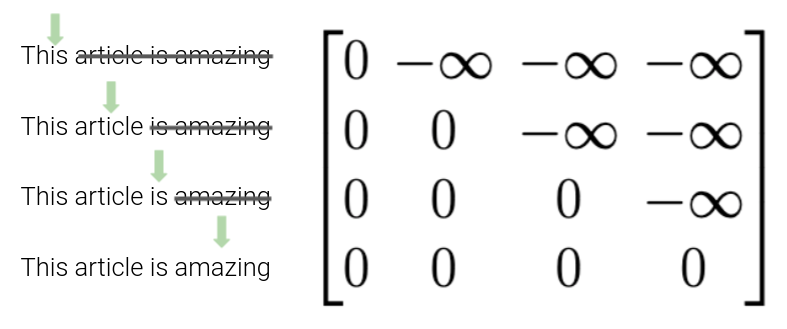

# Padding Masking

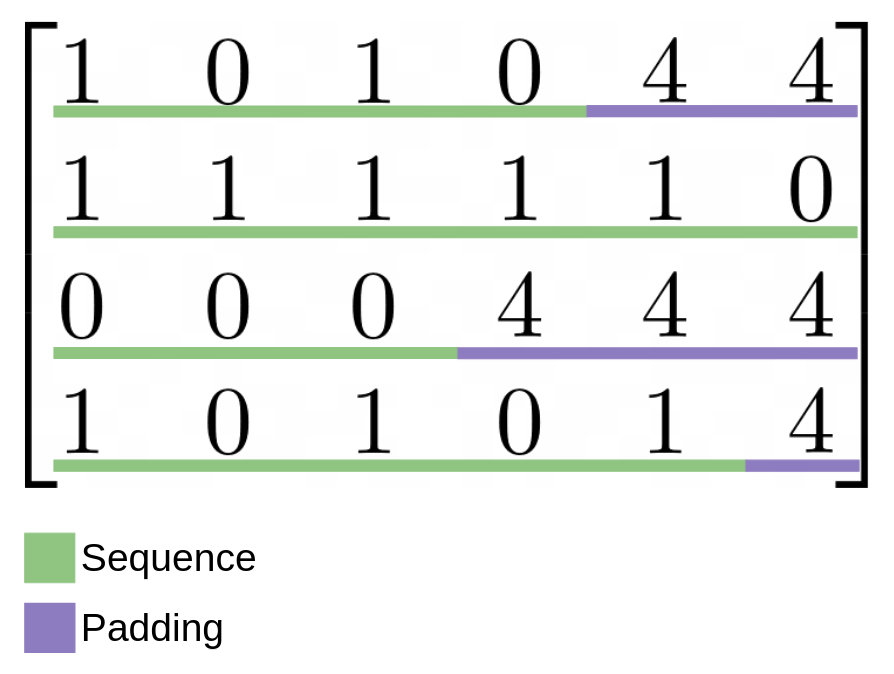

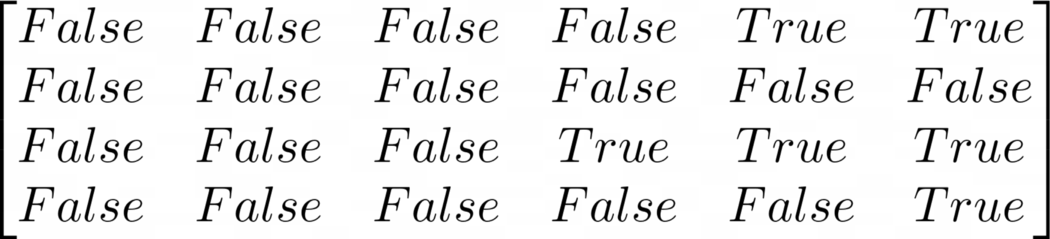

# Transformer class

In [8]:
class Transformer(nn.Module):
    def __init__(self, num_tokens, dim_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_p,
                 ):
        super().__init__()

        # INFO
        self.model_type = 'Transformer'
        self.dim_model = dim_model

        # Layers
        self.positional_encoder = PositionalEncoding(dim_model=dim_model, dropout_p=dropout_p, max_len=5000)
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,  # 트랜스포머의 인코더, 디코더에서 입력과 출력의 크기(default=512)
            nhead=num_heads,    # 멀티헤드 어텐션 모델의 헤드 수 (default=8), 어텐션을 사용할 때 여러 헤드로 분할하여 병렬로 어텐션 수행하고 결과값을 다시 하나로 합치는 방식에서 병렬의 수 
            num_encoder_layers=num_encoder_layers,  # 인코더 총 층수 (default=6)
            num_decoder_layers=num_decoder_layers,  # 디코더 총 층수 (default=6)
            dropout=dropout_p,
            # dim_feedforward  # feedforward 네트워크 모델의 차원, 피드포워드 신경망의 은닉층의 크기 (default=2048)
        )
        self.out = nn.Linear(dim_model, num_tokens)

    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # src, tgt size는 반드시 (batch_size, src sequence length) 

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)

        src = src.permute(1, 0, 2)
        tgt = tgt.permute(1, 0, 2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, 
                                           src_key_padding_mask=src_pad_mask,
                                           tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)

        return out

    def get_tgt_mask(self, size) -> torch.tensor:
        mask = torch.tril(torch.ones(size, size) == 1)  # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask==0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask==1, float(0.0))    # Convert ones to 0

        return mask

    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        return (matrix == pad_token)

In [9]:
a = np.array([2])
a

array([2])

In [10]:
def generate_random_data(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 8
    
    data = []

    # 1,1,1,1,1,1 -> 1,1,1,1,1
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])

    # 0,0,0,0 -> 0,0,0,0
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])

    # 1,0,1,0 -> 1,0,1,0,1
    for i in range(n // 3):
        X = np.zeros(length)
        start = random.randint(0, 1)

        X[start::2] = 1

        y = np.zeros(length)
        if X[-1] == 0:
            y[::2] = 1
        else:
            y[1::2] = 1

        X = np.concatenate((SOS_token, X, EOS_token))
        y = np.concatenate((SOS_token, y, EOS_token))
        data.append([X, y])

    np.random.shuffle(data)

    return data

# size가 16인 배치 형태로 만들어준다
def batchify_data(data, batch_size=16, padding=False, padding_token=-1):
    batches = []
    for idx in range(0, len(data), batch_size):
        # batch_size  크기가 아닌 경우 마지막 비트를 얻지 않도록 한다
        if idx + batch_size < len(data):
            # 여기서 배치의 최대 길이를 가져와 PAD 토큰으로 길이를 정규화해야 한다
            if padding:
                max_batch_length = 0
                # batch에서 가장 긴 문장 가져오기
                for seq in data[idx : idx + batch_size]:
                    if len(seq) > max_batch_length:
                        max_batch_length = len(seq)

                # 최대 길이에 도달할 때까지 X 패딩 토큰을 추가한다
                for seq_idx in range(batch_size):
                    remaining_length = max_batch_length - len(data[idx + seq_idx])
                    data[idx + seq_idx] += [padding_token] * remaining_length
                
            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))

    print(f'{len(batches)} batches of size {batch_size}')
    return batches

In [11]:
train_data = generate_random_data(9000)
val_data = generate_random_data(3000)

train_dataloader = batchify_data(train_data)
val_dataloader = batchify_data(val_data)

562 batches of size 16
187 batches of size 16


# Train and Validation

- optimizer: Stochastic Gradient Descent(SGD) 
- 손실 함수: Cross-Entropy
- learning rate: 0.01

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Transformer(num_tokens=4, dim_model=8, num_heads=2, num_encoder_layers=3, 
                    num_decoder_layers=3, dropout_p=0.1).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

train

In [16]:
def train_loop(model, opt, loss_fn, dataloader):
    model.train()
    total_loss = 0

    for batch in dataloader:
        X, y = batch[:, 0], batch[:, 1]
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # tgt를 1만큼 이동하여 <SOS>를 사용하여 pos 1에서 토큰을 예측한다
        y_input = y[:, :-1]
        y_expected = y[:, 1:]

        # 다음 단어를 마스킹하려면 마스크 가져오기
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # X, y_input, tgt_mask를 전달하여 표준 training
        pred = model(X, y_input, tgt_mask)

        # Permute를 수행하여 batch size 가 처음이 되도록
        pred = pred.permute(1, 2, 0)
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.detach().item()

    return total_loss / len(dataloader)

validation

In [17]:
def validation_loop(model, loss_fn, dataloader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[:, 0], batch[:, 1]
            X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)

            y_input = y[:, :-1]
            y_expected = y[:, 1:]

            sequence_length = y_input.size(1) 
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            pred = model(X, y_input, tgt_mask)

            pred = pred.permute(1, 2, 0)
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()

    return total_loss / len(dataloader)
    

In [18]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    # plot 그리기 위해
    train_loss_list, validation_loss_list = [], []

    print('Training and validating model')
    for epoch in range(epochs):
        print('-'* 25, f'Epoch {epoch+1}', '-' * 25)

        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]

        val_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [val_loss]

        print(f'Training loss: {train_loss:.4f}')
        print(f'Validation loss: {val_loss:.4f}')
        print()

    return train_loss_list, validation_loss_list

train_loss_list, validation_loss_list = fit(model, opt, loss_fn, train_dataloader, val_dataloader, 10)

Training and validating model
------------------------- Epoch 1 -------------------------
Training loss: 0.5236
Validation loss: 0.3955

------------------------- Epoch 2 -------------------------
Training loss: 0.4046
Validation loss: 0.3580

------------------------- Epoch 3 -------------------------
Training loss: 0.3643
Validation loss: 0.2947

------------------------- Epoch 4 -------------------------
Training loss: 0.3205
Validation loss: 0.2397

------------------------- Epoch 5 -------------------------
Training loss: 0.2875
Validation loss: 0.2054

------------------------- Epoch 6 -------------------------
Training loss: 0.2652
Validation loss: 0.1893

------------------------- Epoch 7 -------------------------
Training loss: 0.2486
Validation loss: 0.1704

------------------------- Epoch 8 -------------------------
Training loss: 0.2400
Validation loss: 0.1648

------------------------- Epoch 9 -------------------------
Training loss: 0.2313
Validation loss: 0.1567

-------

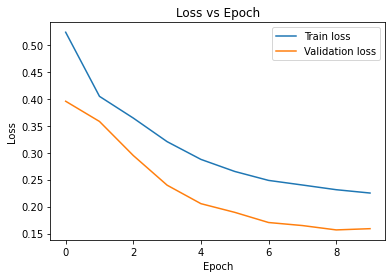

In [21]:
from matplotlib import pyplot as plt
plt.plot(train_loss_list, label='Train loss')
plt.plot(validation_loss_list, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

inference

In [22]:
def predict(model, input_sequence, max_length=15, SOS_token=2, EOS_token=3):
    model.eval()

    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)

        pred = model(input_sequence, y_input, tgt_mask)

        next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()


# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([[2, 0, 0, 0, 0, 0, 0, 0, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 3]], dtype=torch.long, device=device)
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()

Example 0
Input: [0, 0, 0, 0, 0, 0, 0, 0]
Continuation: [0, 0, 0, 0, 0, 0, 0, 0, 0]

Example 1
Input: [1, 1, 1, 1, 1, 1, 1, 1]
Continuation: [1, 1, 1, 1, 1, 1, 1, 1, 1]

Example 2
Input: [1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [1, 0, 1, 0, 1, 0, 1, 0, 1]

Example 3
Input: [0, 1, 0, 1, 0, 1, 0, 1]
Continuation: [1, 0, 1, 0, 1, 0, 1, 0, 1]

Example 4
Input: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1, 0]

Example 5
Input: [0, 1]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1, 0]

